# **Open-world: Multi-Class Classification**
In this notebook, we conduct Open-world experiments using the Random Forest model selected during the previous model selection process. Here, we perform **multi-class classification** to categorize the web traffic traces of 95 monitored websites using their labels.

In this multi-class setup, instances of monitored websites are assigned labels {0, 1, 2, ..., 94}, while instances of unmonitored websites are assigned the label '-1'.

# 1. Determine confidence using the monitored dataset


## 1. Data Preprocessing

In [ ]:
# Load Monitored Dataset
# Convert specific features of the monitored dataset 'mon_standart.pkl' into arrays.

import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading monitored datafile...")
with open("/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000

Loading monitored datafile...
Total samples: 19000


## 2. Feature Extraction

In [ ]:
# Feature extraction

import pandas as pd
import numpy as np

# A function to calculate the number of incoming/outgoing packets for the first 30 packets in each row
def count_in_out_first_30(X2):
    n_in_first = [] # Number of incoming packets for the first 30 packets
    n_out_first = [] # # Number of outgoing packets for the first 30 packets

    for packets in X2:
        # Calculate n_in_first and n_out_first for the first 30 packets
        n_in_f = sum(1 for packet in packets[:30] if packet > 0)
        n_out_f = sum(1 for packet in packets[:30] if packet < 0)

        # Append each result to the respective lists
        n_in_first.append(n_in_f)
        n_out_first.append(n_out_f)

    return n_in_first, n_out_first

# A function to calculate basic features
def compute_features(X2, X1):
    n_pkt = []  # Total number of packets
    n_in = []  # Number of incoming packets
    n_out = []  # Number of outgoing packets
    r_in = []  # Number of incoming packets as a fraction of the total number
    r_out = []  # Number of outgoing packets as a fraction of the total number
    n_pkt_persec = []  # Packets per second

    for i in range(0, len(X2)):
        cnt_in = 0
        for j in range(0, len(X2[i])):
            if X2[i][j] < 0:
                cnt_in += 1
        n_pkt.append(len(X2[i]))
        n_in.append(cnt_in)
        n_out.append(len(X2[i]) - cnt_in)
        r_in.append(cnt_in / len(X2[i]) if len(X2[i]) > 0 else 0)
        r_out.append(1 - (cnt_in / len(X2[i])) if len(X2[i]) > 0 else 0)
        t = X1[i][-1] - X1[i][0] if len(X1[i]) > 1 else 1
        n_pkt_persec.append(n_pkt[i] / t if t > 0 else 0)

    n_in_first, n_out_first = count_in_out_first_30(X2)

    # Create a dataframe
    df_mon = pd.DataFrame({
        'n_pkt': n_pkt,
        'n_in': n_in,
        'n_out': n_out,
        'r_in': r_in,
        'r_out': r_out,
        'n_in_first': n_in_first,
        'n_out_first': n_out_first,
        'n_pkt_persec': n_pkt_persec
    })

    return df_mon

# A function to calculate the standard deviation of outgoing packets
def outgoing_packet_std(X2):
    std_list = []

    for packets in X2:
        outgoing_indices = [i for i, packet in enumerate(packets) if packet < 0]

        if len(outgoing_indices) == 0:
            std_list.append(0)
        else:
            std_list.append(np.std(outgoing_indices))

    return std_list

# A function to calculate the number of packets in the last 5 seconds
def count_packets_last_5_seconds(X1):
    n_last_5s = []
    for timestamps in X1:
        if not timestamps:
            n_last_5s.append(0)
        else:
            end_time = timestamps[-1]
            start_time = end_time - 5
            n_last_5s.append(sum(1 for t in timestamps if t > start_time))
    return n_last_5s

# A function to calculate newly added features
def add_new_features(df_mon, X2, X1):
    sum_alt_concentration = [sum(abs(packet) for packet in packets) for packets in X2]
    df_mon['sum_alt_concentration'] = sum_alt_concentration # Sum of absolute packet size

    alt_pkt_persec = [
        sum(abs(packet) for packet in packets) / (X1[i][-1] - X1[i][0]) if len(packets) > 1 and X1[i][-1] > X1[i][0] else 0 for i, packets in enumerate(X2)
    ]
    df_mon['alt_pkt_persec'] = alt_pkt_persec # Average absolute packet size per second

    df_mon['std_ordering'] = [pd.Series(packets).std() for packets in X2] # Standard Deviation of Packet Sizes

    outgoing_std = outgoing_packet_std(X2)
    df_mon['std_dev of outgoing'] = outgoing_std # Standard Derivation of Outgoing Packets

    cumulative_pkt_size = [sum(map(abs, packets)) for packets in X2]
    df_mon['cumulative_pkt_size'] = cumulative_pkt_size # Cumulative packet Size

    avg_burst_interval = []
    for i in range(len(X1)):
        burst_intervals = [X1[i][j+1] - X1[i][j] for j in range(len(X1[i])-1) if abs(X2[i][j]) > 0]
        avg_burst_interval.append(sum(burst_intervals) / len(burst_intervals) if burst_intervals else 0)
    df_mon['avg_burst_interval'] = avg_burst_interval # Average of Burst Interval

    std_time_interval = [np.std([X1[i][k+1] - X1[i][k] for k in range(len(X1[i])-1)]) if len(X1[i]) > 1 else 0 for i in range(len(X1))]
    df_mon['std_time_interval'] = std_time_interval # Standard Deviation of Time Intervals

    sum_alternate_pkt_per_sec = []
    for packets in X2:
        count = 0
        for i in range(1, len(packets)):
            if (packets[i] > 0 and packets[i-1] < 0) or (packets[i] < 0 and packets[i-1] > 0):
                count += 1
        sum_alternate_pkt_per_sec.append(count)

    df_mon['sum_alternate_pkt_per_sec'] = sum_alternate_pkt_per_sec # Number of packets changing direction per second in each sample

    df_mon['#of_packets_in_last_5_seconds'] = count_packets_last_5_seconds(X1) # Number of packets during the last 5 seconds

    return df_mon

In [ ]:
# Generate features for monitored data
df_mon = compute_features(X2, X1)
df_mon = add_new_features(df_mon, X2, X1)

# Pearson correlation coefficient between packet size and timestamps (mon)
df_mon['size_time_corr'] = [
    pd.Series(packets).corr(pd.Series(times)) if len(packets) > 1 else np.nan
    for packets, times in zip(X2, X1)
]

# Add label column for monitored data
df_mon['label'] = y

In [ ]:
# Check the Monitored DataFrame created with the features
print("mon")
df_mon.head()

mon


,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr,label
0,1421,1300,121,0.914849,0.085151,9,21,140.138067,727552,71750.690335,285.905893,398.486335,727552,0.007141,0.041168,155,179,0.068924,0
1,518,438,80,0.845560,0.154440,8,22,50.984252,265216,26103.937008,370.400747,150.591146,265216,0.019652,0.163930,93,236,-0.104867,0
2,1358,1240,118,0.913108,0.086892,7,23,122.232223,695296,62582.898290,288.543964,381.878642,695296,0.008187,0.066661,151,303,0.081140,0
3,1446,1324,122,0.915629,0.084371,9,21,108.233533,740352,55415.568862,284.712015,406.205288,740352,0.009246,0.047809,159,161,0.090254,0
4,1406,1291,115,0.918208,0.081792,8,22,132.142857,719872,67657.142857,280.725055,395.028889,719872,0.007573,0.038760,157,167,0.090400,0


## 3. Train and Test the model

In [ ]:
!pip install psutil

import psutil

# Check RAM
ram = psutil.virtual_memory()
print(f"Total: {ram.total / (1024 ** 3):.2f} GB")
print(f"Used: {ram.used / (1024 ** 3):.2f} GB")
print(f"Available: {ram.available / (1024 ** 3):.2f} GB")

# Check CPU
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical cores")
print(f"Logical CPUs: {psutil.cpu_count(logical=True)} logical CPUs")

# Check disk space
partitions = psutil.disk_partitions()
for partition in partitions:
    usage = psutil.disk_usage(partition.mountpoint)
    print(f"Device: {partition.device}")
    print(f"Total: {usage.total / (1024 ** 3):.2f} GB")
    print(f"Used: {usage.used / (1024 ** 3):.2f} GB")
    print(f"Free: {usage.free / (1024 ** 3):.2f} GB")
    print(f"Percent Used: {usage.percent}%")

Total: 15.68 GB
Used: 14.52 GB
Available: 1.15 GB
CPU Cores: 14 physical cores
Logical CPUs: 20 logical CPUs
Device: C:\
Total: 476.18 GB
Used: 113.40 GB
Free: 362.77 GB
Percent Used: 23.8%


In [ ]:
# Train and Test

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

X = df_mon[df_mon.columns[:-1]] # Use all features
y = df_mon['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Train RandomForest Model
clf = RandomForestClassifier(n_estimators=1000, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=2)
clf.fit(X_train, y_train)

# Test model
y_pred = clf.predict(X_test)

In [ ]:
# Model Evaluation
# Model Evaluation Metric: f1-score per class
# The f1-score is the harmonic mean of precision and recall, making it a useful metric for evaluating the overall performance of the model.

body = classification_report(y_test, y_pred, output_dict = True) # Returns the results in dictionary format
report_df = pd.DataFrame(body).T # Converts the dictionary to a DataFrame and transposes it (to resemble a typical table view)
f1_each_class = report_df['f1-score'][:-3] #  Selects only the F1-scores from the DataFrame (excluding the last three columns which store accuracy, macro avg, and weighted avg)
f1_per_class = f1_each_class.tolist() # Converts f1_each_class to a list

print(f1_per_class)

[0.7415730337078651, 0.7466666666666666, 0.9487179487179489, 0.8571428571428571, 0.8831168831168831, 0.8444444444444444, 0.8712871287128713, 0.9117647058823528, 0.8831168831168831, 0.7954545454545453, 0.8679245283018867, 0.8059701492537314, 0.9295774647887325, 0.547945205479452, 0.7234042553191489, 0.9047619047619047, 0.7586206896551724, 0.810126582278481, 0.8918918918918918, 0.8108108108108109, 0.963855421686747, 0.6835443037974684, 0.6, 0.9367088607594937, 0.6470588235294118, 0.7164179104477612, 0.8387096774193549, 0.8266666666666667, 0.8085106382978723, 0.7536231884057971, 0.868421052631579, 0.8358208955223881, 0.6666666666666666, 0.7999999999999998, 0.6666666666666666, 0.8674698795180724, 0.8888888888888888, 0.75, 0.8089887640449439, 0.8169014084507044, 0.8571428571428571, 0.8684210526315789, 0.7126436781609196, 0.9, 0.9473684210526315, 0.6666666666666667, 0.8493150684931507, 0.6913580246913581, 0.8205128205128205, 0.8108108108108109, 0.878048780487805, 0.6666666666666666, 0.849315

Result: Best Model's Performance
- Accuracy on test dataset: **0.9043181818181818**
- Precision on test dataset: 0.9043181818181818

## 4. Optimizing Criteria for Classifying Unmonitored Dataset
To optimize the criteria for determining the class when classifying the unmonitored dataset, two methods are considered.

Method 1) Considering **only the probability of the top-ranked predicted class** (based on the largest F1-score)


1. For each test data point, sort the probabilities for the predicted classes in ascending order.
2. If the prediction is correct, store the probability of the top-ranked predicted class in first_proba_c.
3. If the prediction is incorrect, store the probability of the top-ranked predicted class in first_proba_w.

Method 2) Considering **both the F1-score and the probability of the top-ranked predicted class** (confidence)

To assign greater trust to the prediction, confidence can be used. Confidence is defined as the product of the F1-score of the predicted class and the probability of that class.

1. Calculate and store the confidence for correct predictions.
2. Calculate and store the confidence for incorrect predictions.

In [ ]:
probabilities = clf.predict_proba(X_test) # Predict using the RandomForest model
sorted_indexes = np.argsort(probabilities, axis=1) # Sort the predicted class probabilities for each test data in ascending order.

first_proba_c =[] # Top 1 probability (Correct cases)
first_proba_w =[] # Top 1 probability (Wrong cases).

confidence_c = []
confidence_w = []
confidence_all = []

# Store the corresponding values for all test cases (3800) in these 4 arrays.
proba_top = [] # Save all top 1 probabilities regardless of correct or wrong
tf_label = [] # Save whether the prediction is correct(1) or wrong(0)

# Output the probability array and the actual class for each test data
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class {pred_class}")
    f1_score_pred = f1_per_class[pred_class]
    confidence_score = f1_score_pred * probabilities[i][pred_class]

    for index in sorted_index[::-1][:3]: # Output the top 3 predicted classes by probability
      print(f"Predicted Class {index}: {probabilities[i][index]}")

    first_proba = probabilities[i][sorted_index[-1]] # Top 1 probability
    proba_top.append(first_proba)
    confidence_all.append(confidence_score)

    if true_class == pred_class:
        print("✓ Correct Prediction! ")
        first_proba_c.append(first_proba)  # Save the top 1 probability (for plotting)
        tf_label.append(1)
        confidence_c.append(confidence_score)
    else:
      print("✕✕ Wrong Prediction...")
      first_proba_w.append(first_proba)  # Save the largest probability
      tf_label.append(0)
      confidence_w.append(confidence_score)
    print(">> Confidence: ", confidence_score)
    print()

Test Data 1 - True Class: 11, Predicted Class 91
Predicted Class 91: 0.316
Predicted Class 35: 0.236
Predicted Class 11: 0.196
✕✕ Wrong Prediction...
>> Confidence:  0.27925581395348836

Test Data 2 - True Class: 94, Predicted Class 94
Predicted Class 94: 0.278
Predicted Class 0: 0.173
Predicted Class 8: 0.112
✓ Correct Prediction! 
>> Confidence:  0.21728735632183913

Test Data 3 - True Class: 12, Predicted Class 12
Predicted Class 12: 0.469
Predicted Class 15: 0.114
Predicted Class 61: 0.072
✓ Correct Prediction! 
>> Confidence:  0.4359718309859155

Test Data 4 - True Class: 83, Predicted Class 83
Predicted Class 83: 0.898
Predicted Class 7: 0.068
Predicted Class 10: 0.008
✓ Correct Prediction! 
>> Confidence:  0.7662933333333333

Test Data 5 - True Class: 85, Predicted Class 85
Predicted Class 85: 0.979
Predicted Class 90: 0.008
Predicted Class 64: 0.003
✓ Correct Prediction! 
>> Confidence:  0.905575

Test Data 6 - True Class: 94, Predicted Class 94
Predicted Class 94: 0.707
Predic

### Result : Method 1
Considering only the probability of the top-ranked predicted class (based on the largest F1-score):


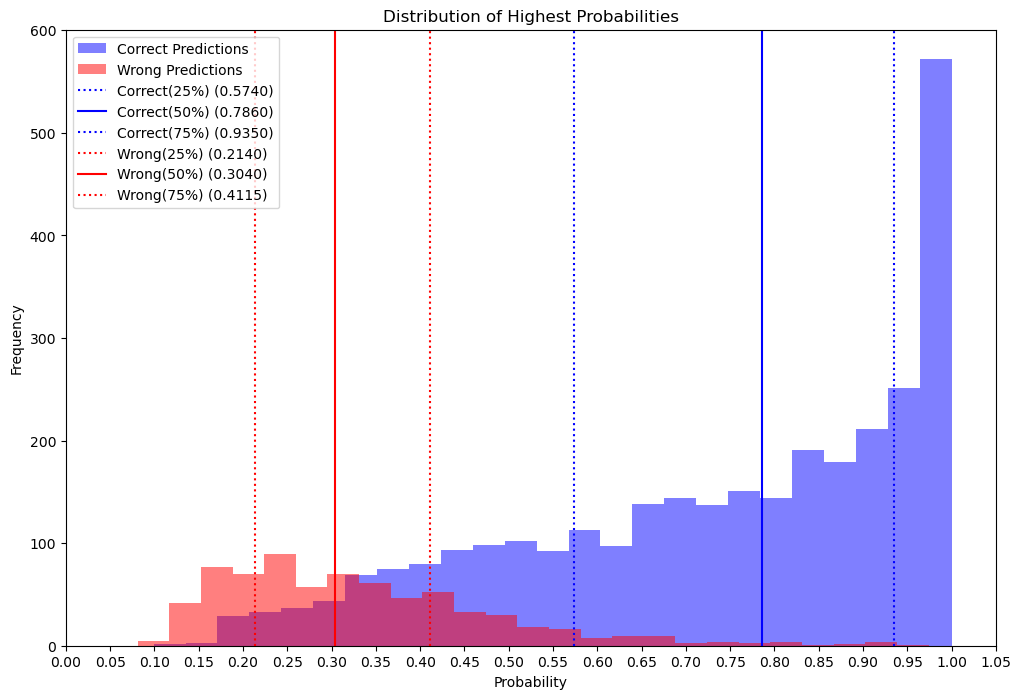

In [ ]:
import matplotlib.pyplot as plt

q1_first_proba_c = np.percentile(first_proba_c, 25)
q2_first_proba_c = np.percentile(first_proba_c, 50)
q3_first_proba_c = np.percentile(first_proba_c, 75)

q1_first_proba_w = np.percentile(first_proba_w, 25)
q2_first_proba_w = np.percentile(first_proba_w, 50)
q3_first_proba_w = np.percentile(first_proba_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(first_proba_c, bins=25, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(first_proba_w, bins=25, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_first_proba_c, color='blue', linestyle='dotted', label=f'Correct(25%) ({q1_first_proba_c:.4f})')
plt.axvline(x=q2_first_proba_c, color='blue', linestyle='-', label=f'Correct(50%) ({q2_first_proba_c:.4f})')
plt.axvline(x=q3_first_proba_c, color='blue', linestyle='dotted', label=f'Correct(75%) ({q3_first_proba_c:.4f})')

plt.axvline(x=q1_first_proba_w, color='red', linestyle='dotted', label=f'Wrong(25%) ({q1_first_proba_w:.4f})')
plt.axvline(x=q2_first_proba_w, color='red', linestyle='-', label=f'Wrong(50%) ({q2_first_proba_w:.4f})')
plt.axvline(x=q3_first_proba_w, color='red', linestyle='dotted', label=f'Wrong(75%) ({q3_first_proba_w:.4f})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Highest Probabilities')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # Set the x-axis ticks from 0 to 1 with intervals of 0.05
plt.show()

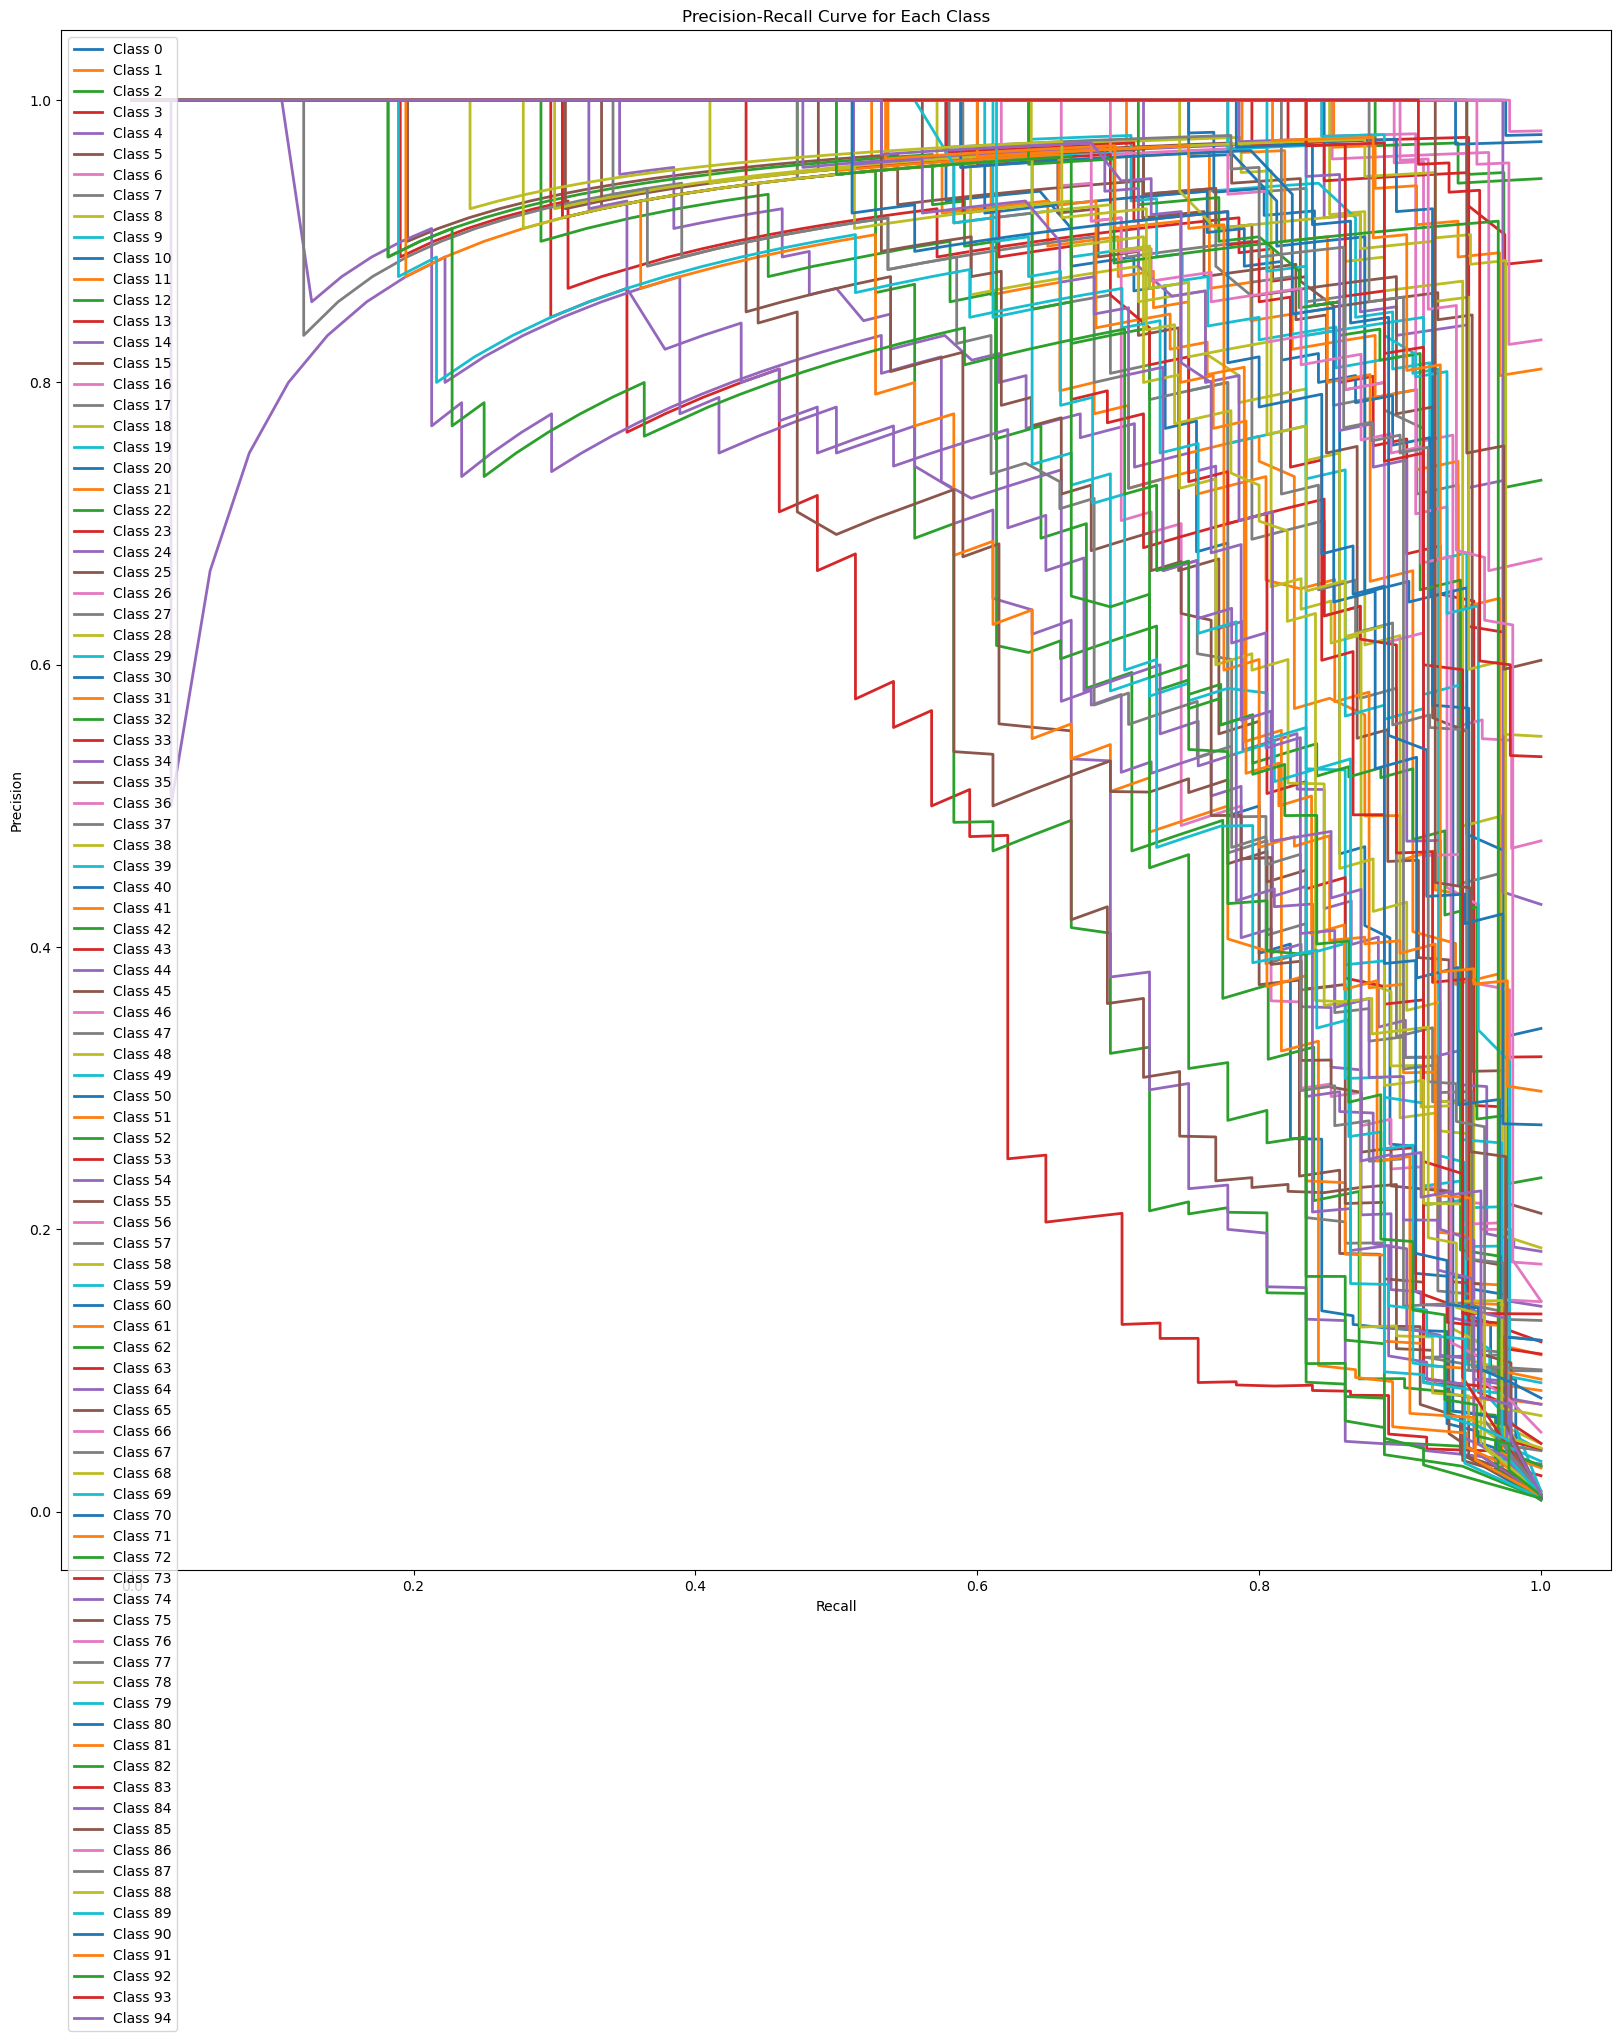

In [ ]:
# Plotting Precision-Recall Curve for Overall and Each Class

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = clf.predict_proba(X_test)

# Precision-Recall curve
precision = dict()
recall = dict()
plt.figure(figsize=(20, 20))

for i in range(len(set(y_test))):  # Calculate Precision and Recall for each class
    precision[i], recall[i], _ = precision_recall_curve((y_test == i).astype(int), y_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve for Each Class')
plt.show()


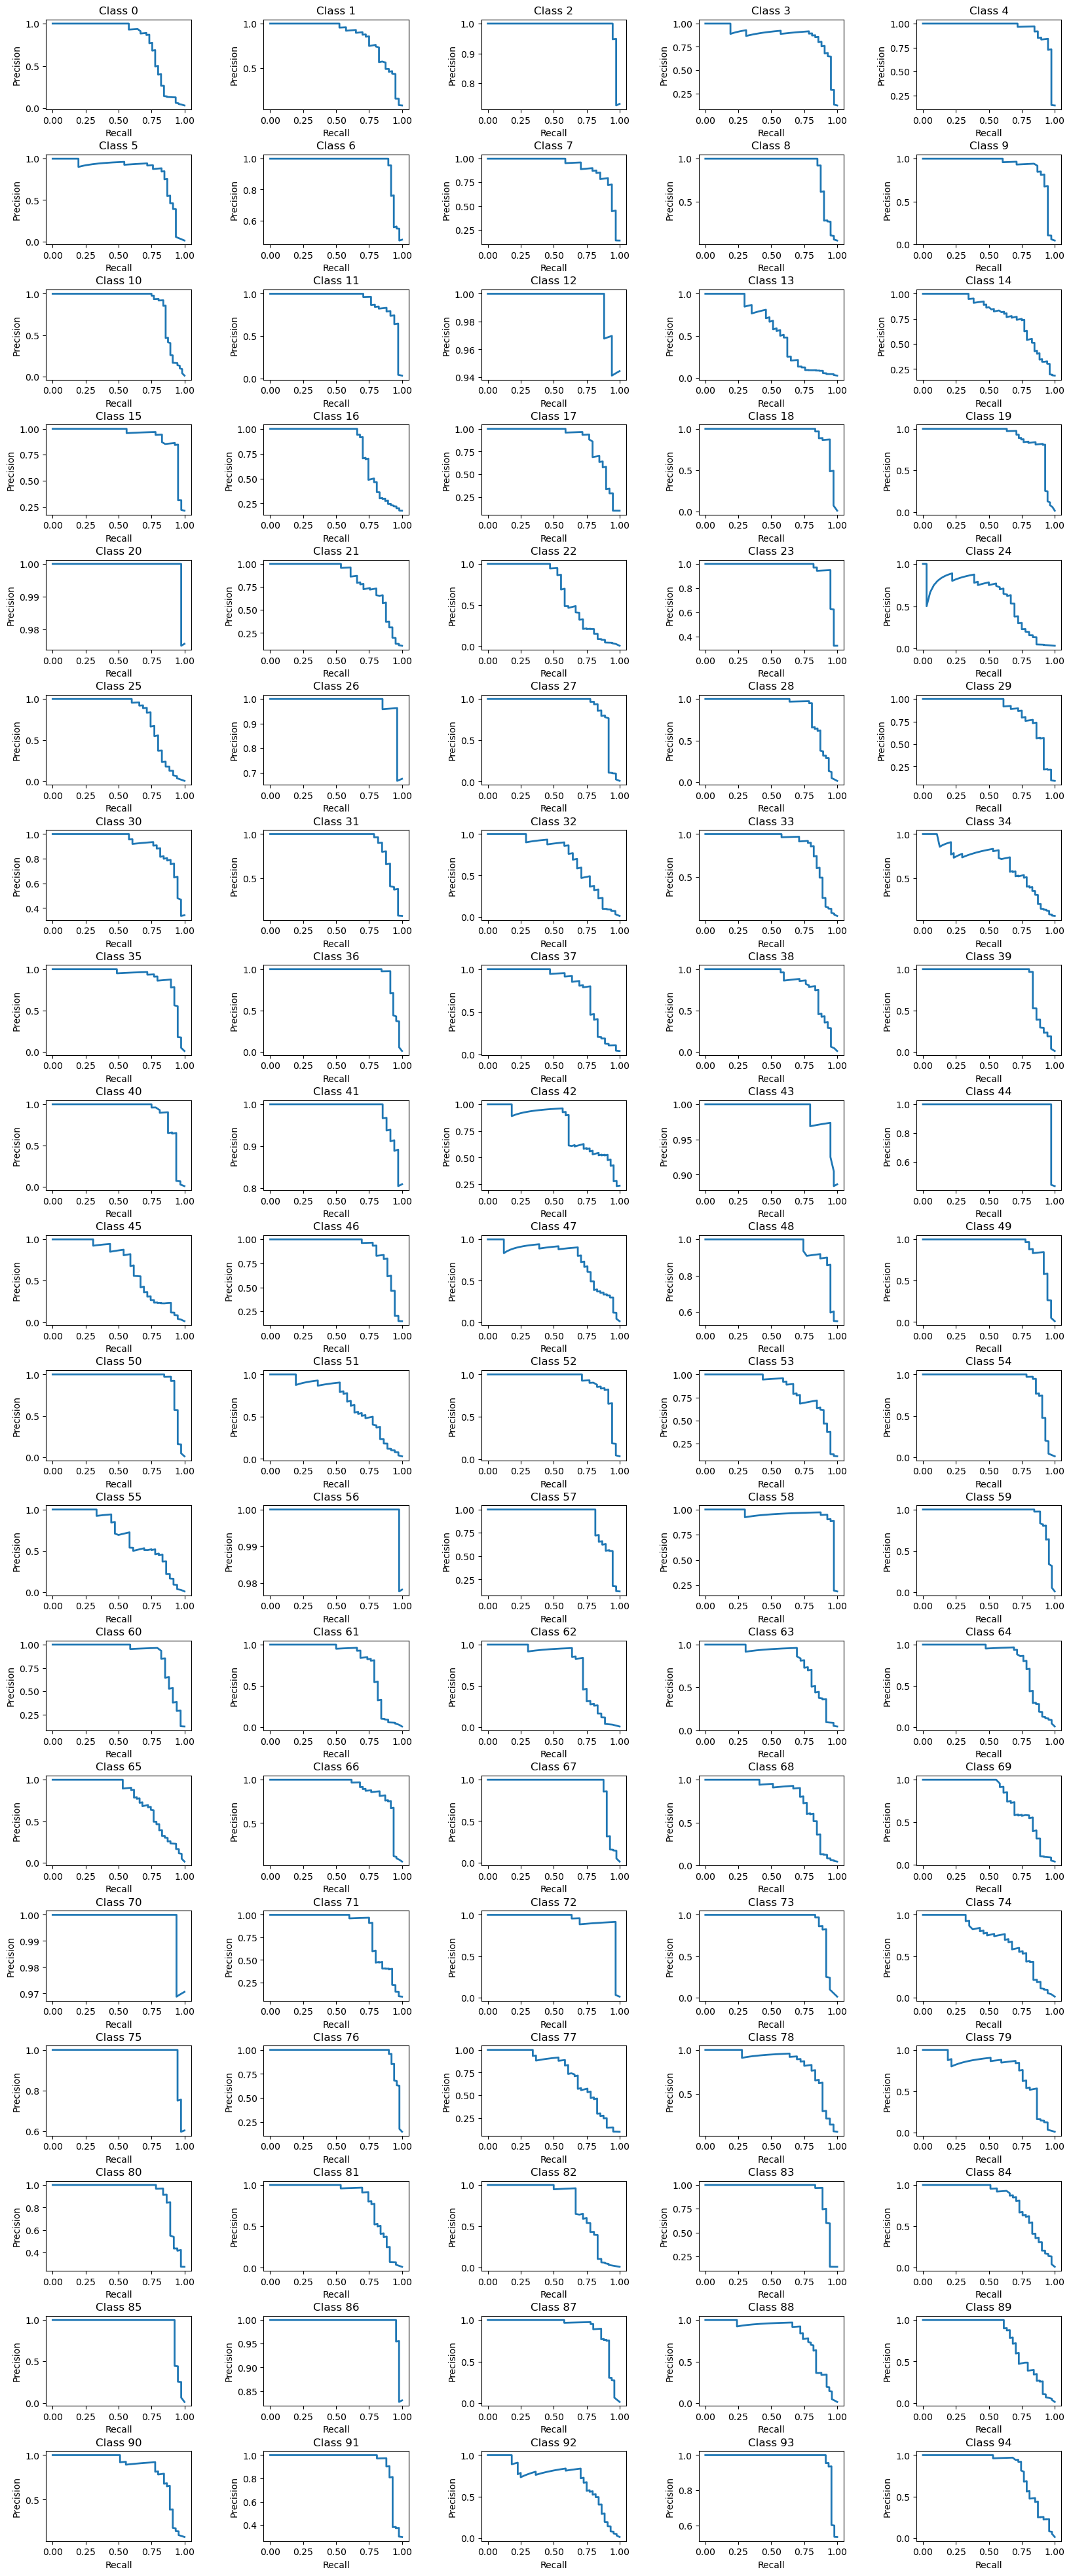

In [ ]:
# Display the results for each class

precision = dict()
recall = dict()

fig, axes = plt.subplots(nrows=19, ncols=5, figsize=(20, 50))
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # adjust subplot space

for i in range(19):  # row
    for j in range(5):  # col
        idx = i * 5 + j
        if idx >= len(set(y_test)):
            break

        precision[idx], recall[idx], _ = precision_recall_curve((y_test == idx).astype(int), y_probs[:, idx])
        axes[i, j].plot(recall[idx], precision[idx], lw=2)
        axes[i, j].set_xlabel('Recall')
        axes[i, j].set_ylabel('Precision')
        axes[i, j].set_title(f'Class {idx}')

plt.show()

It can be observed that classes such as 24 and 92 do not show positive classification results.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

p_thresholds = np.unique(proba_top)  # Set the unique values in proba_top as thresholds
best_p_f1 = -1
best_p_threshold = None

# Calculate the f1-score for each threshold.
for p_threshold in p_thresholds:
    predicted_label = (proba_top >= p_threshold).astype(int) # Mark as true if the value is greater than or equal to the threshold
    f1 = f1_score(tf_label, predicted_label)

    # Update the threshold value only if it results in a higher f1-score.
    if f1 > best_p_f1:
        best_p_f1 = f1
        best_p_threshold = p_threshold

print("Best threshold (largest probability criterion):", best_p_threshold)
print("Best f1-score:", best_p_f1)

# Obtain predicted labels based on the best_threshold
predicted_labels = (proba_top >= best_p_threshold).astype(int)

# Compute the confusion matrix
conf1_matrix = confusion_matrix(tf_label, predicted_labels)
print("Confusion Matrix:")
print(conf1_matrix)

# Calculate accuracy, precision, and recall.
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best threshold (largest probability criterion): 0.315
Best f1-score: 0.9248663942156555
Confusion Matrix:
[[ 380  335]
 [ 143 2942]]
Accuracy: 0.8742
Precision: 0.8978
Recall: 0.9536


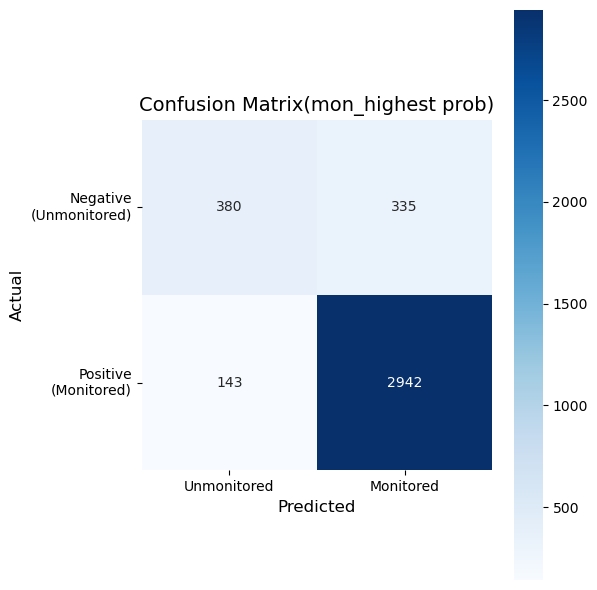

In [ ]:
# Visualize Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6, 6))
sns.heatmap(conf1_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)

plt.title("Confusion Matrix(mon_highest prob)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.xticks([0.5, 1.5], ["Unmonitored", "Monitored"], rotation=0)
plt.yticks([0.5, 1.5], ["Negative\n(Unmonitored)", "Positive\n(Monitored)"], rotation=0)

plt.tight_layout()
plt.show()

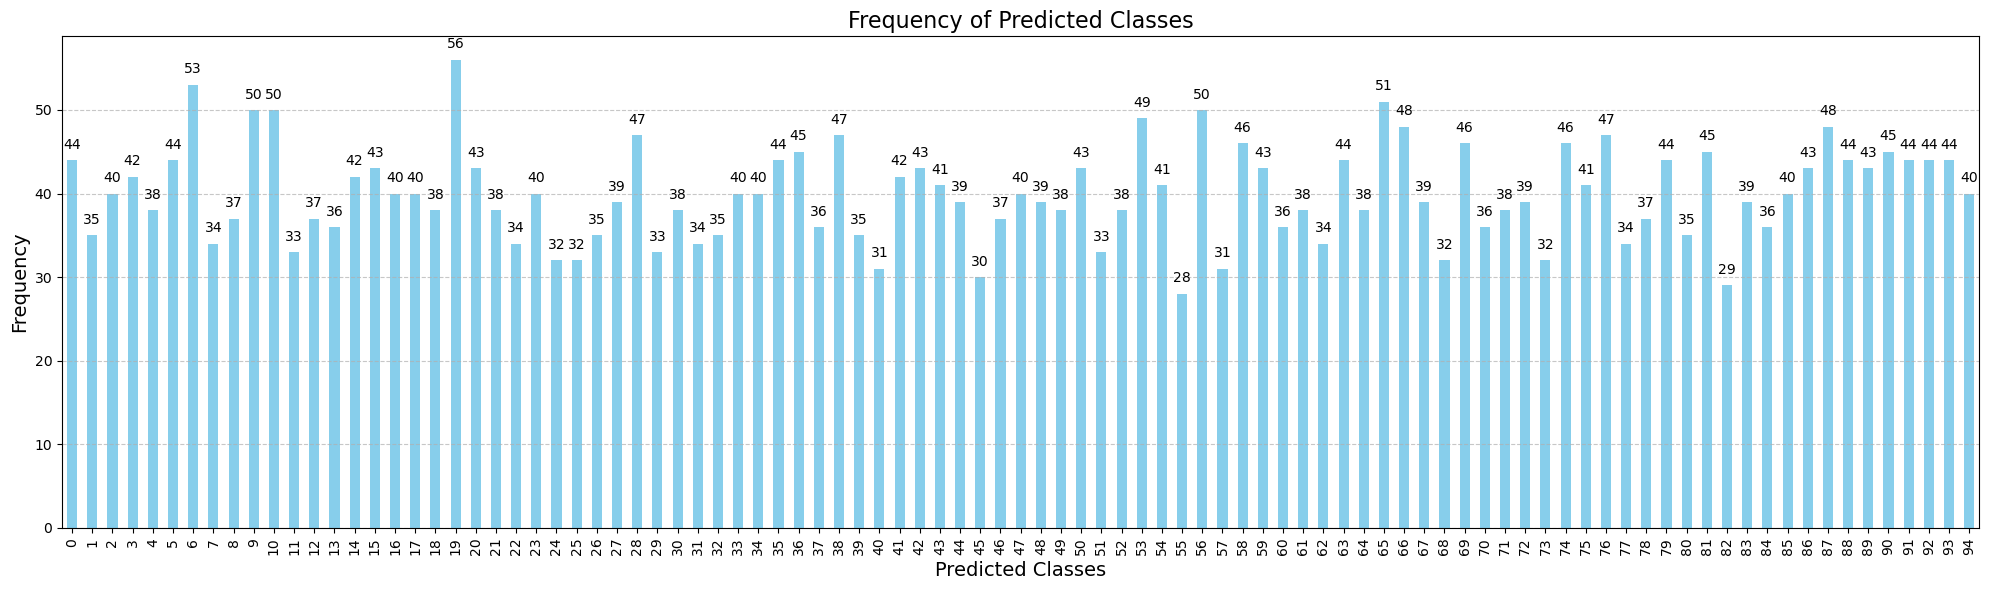

In [ ]:
# Visualize Frequency of Predicted Classes

import matplotlib.pyplot as plt
import pandas as pd

# Calculate the frequency of each class
class_counts = pd.Series(y_pred).value_counts().sort_index()

plt.figure(figsize=(20, 6))
bars = class_counts.plot(kind='bar', color='skyblue')

for index, value in enumerate(class_counts):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Frequency of Predicted Classes', fontsize=16)
plt.xlabel('Predicted Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Result : Method 2
Considering both the F1-score and the probability of the top-ranked predicted class (confidence)

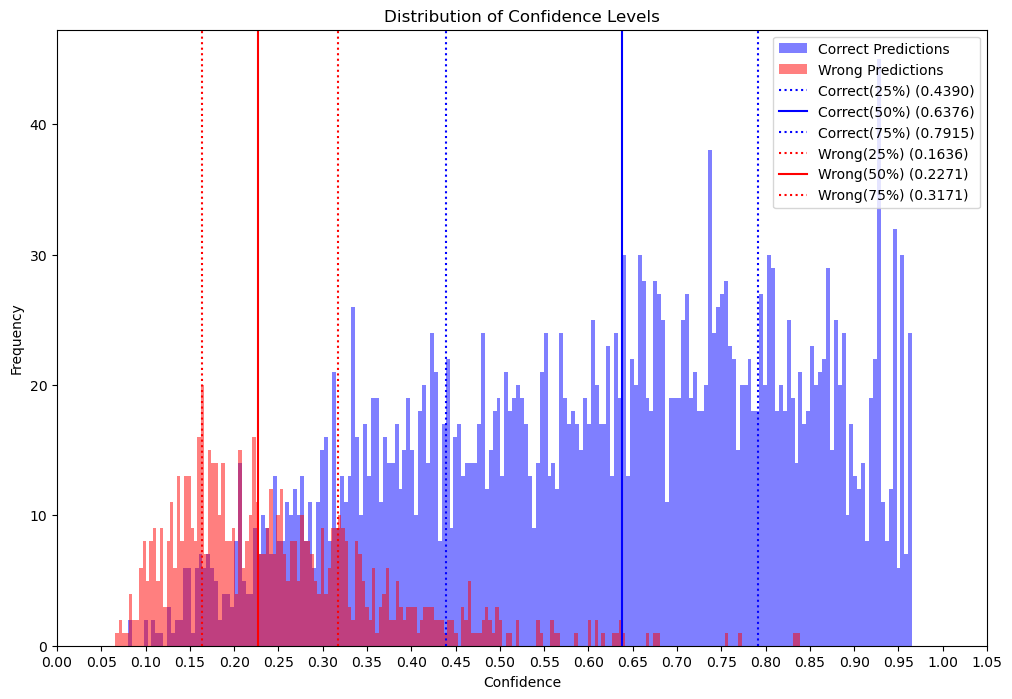

In [ ]:
import matplotlib.pyplot as plt

# Calculate the top 25%, 50%, and bottom 25% values for confidence_c and confidence_w
q1_confidence_c = np.percentile(confidence_c, 25)
q2_confidence_c = np.percentile(confidence_c, 50)
q3_confidence_c = np.percentile(confidence_c, 75)
q1_confidence_w = np.percentile(confidence_w, 25)
q2_confidence_w = np.percentile(confidence_w, 50)
q3_confidence_w = np.percentile(confidence_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(confidence_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(confidence_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_confidence_c, color='blue', linestyle='dotted', label=f'Correct(25%) ({q1_confidence_c:.4f})')
plt.axvline(x=q2_confidence_c, color='blue', linestyle='-', label=f'Correct(50%) ({q2_confidence_c:.4f})')
plt.axvline(x=q3_confidence_c, color='blue', linestyle='dotted', label=f'Correct(75%) ({q3_confidence_c:.4f})')

plt.axvline(x=q1_confidence_w, color='red', linestyle='dotted', label=f'Wrong(25%) ({q1_confidence_w:.4f})')
plt.axvline(x=q2_confidence_w, color='red', linestyle='-', label=f'Wrong(50%) ({q2_confidence_w:.4f})')
plt.axvline(x=q3_confidence_w, color='red', linestyle='dotted', label=f'Wrong(75%) ({q3_confidence_w:.4f})')

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Levels')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # Set the x-axis ticks from 0 to 1 with intervals of 0.05
plt.show()

In [ ]:
conf_threshold = np.unique(confidence_all)  # Set the unique values in confidence_all as thresholds
best_confidence_f1 = -1
best_confidence_threshold = None

# Calculate the f1-score for each threshold
for confidence_threshold in conf_threshold:
    predicted_label = (confidence_all >= confidence_threshold).astype(int) # threshold 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # Update the threshold value only if it results in a higher f1-score
    if f1 > best_confidence_f1:
        best_confidence_f1 = f1
        best_confidence_threshold = confidence_threshold

print("Best threshold (confidence criterion):", best_confidence_threshold)
print("Best f1-score:", best_confidence_f1)

# Obtain predicted labels based on the best_threshold
predicted_labels = (confidence_all >= best_confidence_threshold).astype(int)

# Compute confusion matrix
conf2_matrix = confusion_matrix(tf_label, predicted_labels)
print("Confusion Matrix:")
print(conf2_matrix)

# Compute accuracy, precision, recall
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best threshold (confidence criterion): 0.24340298507462688
Best f1-score: 0.925189393939394
Confusion Matrix:
[[ 395  320]
 [ 154 2931]]
Accuracy: 0.8753
Precision: 0.9016
Recall: 0.9501


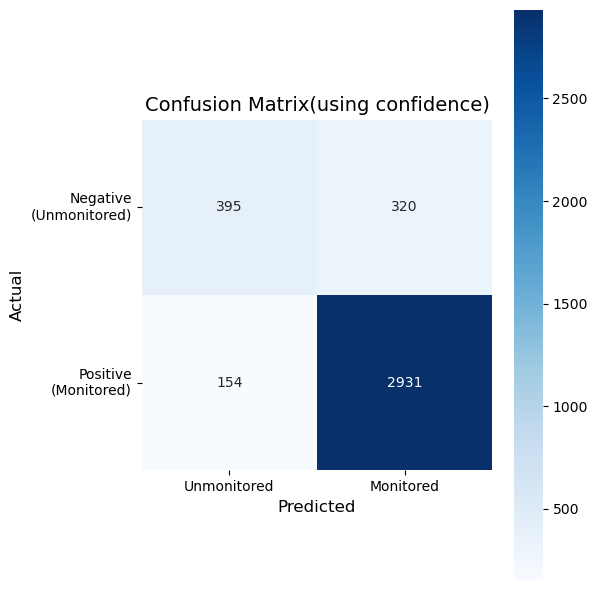

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6, 6))
sns.heatmap(conf2_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)

plt.title("Confusion Matrix(using confidence)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.xticks([0.5, 1.5], ["Unmonitored", "Monitored"], rotation=0)
plt.yticks([0.5, 1.5], ["Negative\n(Unmonitored)", "Positive\n(Monitored)"], rotation=0)

plt.tight_layout()
plt.show()


### Final Result
Best Threshold(confidence criterion): **0.24340298507462688**

# 2. Multi-class classification on the unmonitored dataset

## 1. Data Preprocessing

In [ ]:
# Load Unmonitored Dataset

TOTAL_URLS   = 3000

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('unmon_standard10_3000.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1.append(time_seq)
    X2.append(size_seq)

print(len(X1)) # Print the length of X1

Loading datafile...
Total samples: 3000
3000


## 2. Feature Extraction

In [ ]:
# Generate features for unmonitored data
df_unmon = compute_features(X2, X1)
df_unmon = add_new_features(df_unmon, X2, X1)

# Pearson correlation coefficient between packet size and timestamps (unmon)
df_unmon['size_time_corr'] = [
    pd.Series(packets).corr(pd.Series(times)) if len(packets) > 1 else np.nan
    for packets, times in zip(X2, X1)
]

In [ ]:
df_unmon.head()

,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr
0,130,101,29,0.776923,0.223077,13,17,23.381295,66560,11971.223022,427.950079,36.304696,66560,0.043101,0.105741,34,126,-0.390973
1,9927,9189,738,0.925657,0.074343,12,18,835.606061,5082624,427830.303030,268.637178,2845.096286,5082624,0.001197,0.019357,774,8824,-0.110602
2,359,285,74,0.793872,0.206128,13,17,20.157215,183808,10320.494104,414.810278,100.730751,183808,0.049749,0.249810,75,50,-0.117080
3,9948,9407,541,0.945617,0.054383,9,21,1084.841876,5093376,555439.040349,232.225664,2855.784563,5093376,0.000922,0.017914,731,9922,-0.045137
4,2508,2215,293,0.883174,0.116826,3,27,46.799776,1284096,23961.485352,328.987729,716.374241,1284096,0.021376,0.263498,339,4,0.062707


In [ ]:
df_unmon.tail()

,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr
2995,3219,2847,372,0.884436,0.115564,11,19,218.089431,1648128,111661.788618,327.424861,906.707610,1648128,0.004587,0.051661,395,295,0.100211
2996,3589,3389,200,0.944274,0.055726,3,27,231.548387,1837568,118552.774194,234.929629,1030.091922,1837568,0.004320,0.049700,318,313,-0.011238
2997,3810,3509,301,0.920997,0.079003,11,19,305.288462,1950720,156307.692308,276.252944,1079.856817,1950720,0.003276,0.033860,356,3518,-0.156853
2998,4370,3891,479,0.890389,0.109611,13,17,150.793651,2237440,77206.349206,319.938562,1244.562993,2237440,0.006633,0.209143,402,2,-0.125336
2999,9910,9144,766,0.922704,0.077296,8,22,648.136037,5073920,331845.650752,273.483235,2840.607963,5073920,0.001543,0.017881,830,6979,0.000836


## 3. Multi-class Classification

Assign labels {0, 1, 2, ..., 94} to monitored website instances and the label '-1' to unmonitored website instances.

Calculate confidence:

- If the confidence is smaller than the confidence of monitored data, classify it as unmonitored and assign the label '-1'.
- If the confidence is greater than the confidence of monitored data, assign a label between 0 and 94.

In [ ]:
X_test2 = df_unmon
y_pred2 = clf.predict(X_test2)

In [ ]:
probability = clf.predict_proba(X_test2)
sorted_index = np.argsort(probability, axis=1)
data_list = []
monitored_confidence = []

for i, (sorted_index, pred_class) in enumerate(zip(sorted_index, y_pred2)):
    print(f"Test Data {i + 1}, Predicted Class {pred_class}")
    for j, index in enumerate(sorted_index[::-1][:1]): # Output only the top 1 class with the highest probability
        f1 = f1_per_class[pred_class]
        pred_proba = probability[i][index]
        confidence = pred_proba * f1
        print(f"Predicted Class {index}: {probability[i][index]}")
        print(f"Class {index}의 f1-score: {f1}")
        print(f"Confidence: {confidence}")
        if(confidence >= best_confidence_threshold) :
          data_list.append([i + 1, pred_class, pred_proba, f1, confidence])
          monitored_confidence.append([pred_class, confidence])
        else : # the confidence is smaller than the confidence of mon_data -> classify it as unmonitored and assign the label '-1'
          data_list.append([i + 1, -1, pred_proba, f1, confidence])
          print(f"Confidence < {best_confidence_threshold} --> unmonitored")
    print()

columns = ['Test Data Index', 'Predicted Class', 'Probability', 'f1-score of predicted class','Confidence']
result = pd.DataFrame(data_list, columns=columns)

Test Data 1, Predicted Class 92
Predicted Class 92: 0.422
Class 92의 f1-score: 0.7045454545454546
Confidence: 0.2973181818181818

Test Data 2, Predicted Class 68
Predicted Class 68: 0.491
Class 68의 f1-score: 0.7887323943661971
Confidence: 0.3872676056338028

Test Data 3, Predicted Class 75
Predicted Class 75: 0.205
Class 75의 f1-score: 0.8860759493670887
Confidence: 0.18164556962025316
Confidence < 0.24340298507462688 --> unmonitored

Test Data 4, Predicted Class 0
Predicted Class 0: 0.15
Class 0의 f1-score: 0.7415730337078651
Confidence: 0.11123595505617977
Confidence < 0.24340298507462688 --> unmonitored

Test Data 5, Predicted Class 38
Predicted Class 38: 0.17
Class 38의 f1-score: 0.8089887640449439
Confidence: 0.13752808988764048
Confidence < 0.24340298507462688 --> unmonitored

Test Data 6, Predicted Class 31
Predicted Class 31: 0.238
Class 31의 f1-score: 0.8358208955223881
Confidence: 0.19892537313432837
Confidence < 0.24340298507462688 --> unmonitored

Test Data 7, Predicted Class 44

## 4. Result

In [ ]:
result

,Test Data Index,Predicted Class,Probability,f1-score of predicted class,Confidence
0,1,92,0.422,0.704545,0.297318
1,2,68,0.491,0.788732,0.387268
2,3,-1,0.205,0.886076,0.181646
3,4,-1,0.150,0.741573,0.111236
4,5,-1,0.170,0.808989,0.137528
...,...,...,...,...,...
2995,2996,-1,0.301,0.750000,0.225750
2996,2997,47,0.454,0.691358,0.313877
2997,2998,-1,0.205,0.683544,0.140127
2998,2999,-1,0.174,0.925000,0.160950


# 3. Final Result

The classification results for the unmonitored dataset, categorized into monitored and unmonitored.

In [ ]:
multi_classification_mon = result.loc[result['Predicted Class'] >= 0, ['Test Data Index', 'Predicted Class']]
multi_classification_unmon = result.loc[result['Predicted Class'] == -1, ['Test Data Index', 'Predicted Class']]

In [ ]:
# DataFrame of monitored data classified with labels assigned between 0 and 94
multi_classification_mon

,Test Data Index,Predicted Class
0,1,92
1,2,68
6,7,44
7,8,17
8,9,11
...,...,...
2986,2987,63
2990,2991,86
2991,2992,31
2994,2995,79


In [ ]:
# DataFrame of unmonitored data classified with the label -1
multi_classification_unmon

,Test Data Index,Predicted Class
2,3,-1
3,4,-1
4,5,-1
5,6,-1
11,12,-1
...,...,...
2993,2994,-1
2995,2996,-1
2997,2998,-1
2998,2999,-1


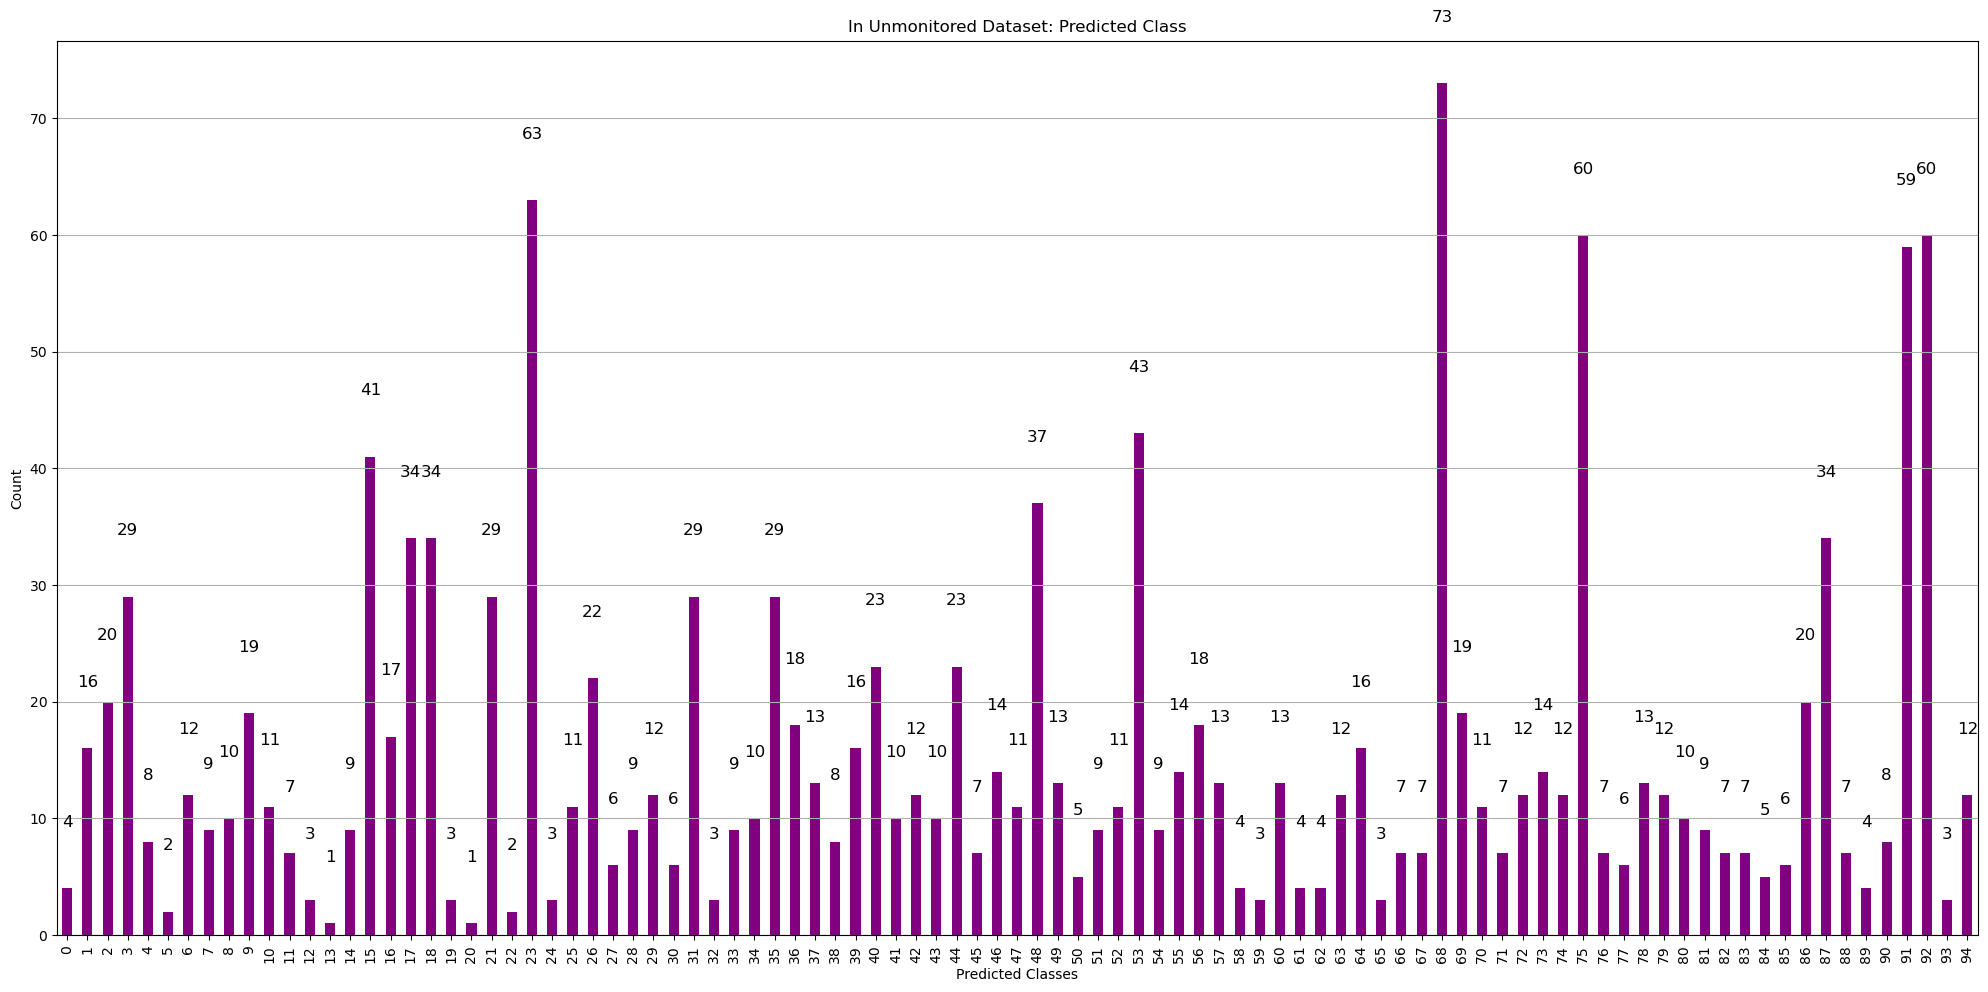

In [ ]:
# Visualize the count of predicted classes
class_counts = multi_classification_mon['Predicted Class'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
class_counts.plot(kind='bar', color='purple')

for index, value in enumerate(class_counts):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12, color='black')

plt.title('In Unmonitored Dataset: Predicted Class')
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.grid(axis='y')

plt.tight_layout()
plt.show()